In [1]:
# %pip install simple-icd-10

In [184]:
# %pip install seaborn

In [185]:
import pandas as pd
import json
import re
import simple_icd_10 as icd
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 1000)

In [89]:
responses = pd.read_csv("responses.tsv", sep="\t")

In [90]:
responses.head()

,Unnamed: 0,response
0,K76,"```json\n{\n ""comment"": ""Patients with live..."
1,R18,"```json\n{\n ""comment"": ""Ascites is often a..."
2,K74,"```json\n{\n ""comment"": ""Patients with fibr..."
3,B19,"```json\n{\n ""comment"": ""A patient with uns..."
4,J44,"```json\n{\n ""comment"": ""Patients with chro..."


In [91]:
responses.loc[0, "response"]

'```json\n{\n    "comment": "Patients with liver diseases (K76) often have comorbidities or complications related to liver dysfunction, such as gastrointestinal bleeding, portal hypertension, or metabolic disorders. Additionally, they might have codes related to alcohol use, viral hepatitis, or other underlying causes of liver disease.",\n    "answer": ["K70", "K71", "K72", "K73", "K74", "K75", "B18", "F10", "I85", "K92"]\n}\n```'

In [92]:
def add_quotation_marks_around_codes(input_str):
    # Use regex to find and quote unquoted list elements
    fixed_str = re.sub(
        r'(?<=\[)([^\[\]\"]+)(?=\])',  # Pattern to match unquoted elements between []
        lambda m: ','.join(f'"{x.strip()}"' for x in m.group(1).split(',')), 
        input_str
    )
    return fixed_str

def fix_json_quotes(input_str):
    # Replace unescaped quotes in string values while preserving existing JSON structure
    fixed_str = re.sub(
        r'(?<=": ")(.*?)(?=",)',  # Match between ": " and ",
        lambda m: m.group(0).replace('"', '\\"'),  # Escape inner quotes
        input_str
    )
    return fixed_str

def get_key(s, key):
    try:
        json_str = s.strip('```json\n').strip('```').strip()
        try:
            data = json.loads(json_str)
            
        except:
            try:
                json_str = add_quotation_marks_around_codes(json_str)
                data = json.loads(json_str)
                
            except:
                json_str = fix_json_quotes(json_str)
                data = json.loads(json_str)
            
        if isinstance(data[key], list):
            return data[key]
        elif isinstance(data[key], str):
            return data[key].strip("[]").split(", ")
        else:
            raise ValueError("{} is not valid".format(data[key]))
    
    except Exception as e:
        print(e)
        print(json_str)
        return None

In [93]:
responses["codes"] = responses["response"].apply(lambda x: get_key(x, "answer"))

In [94]:
responses.sample(10)

,Unnamed: 0,response,codes
1638,Y03,"```json\n{\n ""comment"": ""A patient with an ...","[S00-T88, V01-V99]"
1544,V82,"```json\n{\n ""comment"": ""A patient with an ...","[S00-T88, V00-Y99, Z47-Z49]"
31,K31,"```json\n{\n ""comment"": ""Patients with dise...","[K25, K26, K27, K28, K29, K57, K90, D50]"
970,D43,"```json\n{\n ""comment"": ""Patients with a ne...","[G40, G43, R51, R56, Z51]"
934,O04,"```json\n{\n ""comment"": ""Patients with a me...","[O03, O05, O06, O07, O08, O09, O26, O20]"
1372,L44,"```json\n{\n ""comment"": ""Patients with papu...","[L40, L41, L42, L43, L20, L21, L30, B35]"
1262,D71,"```json\n{\n ""comment"": ""Functional disorde...","[D72, D80, D89, B95, B96, B97, J18, J22]"
324,C54,"```json\n{\n ""comment"": ""A patient with a m...","[C53, C79, D50-D64, Z51.1, Z51.0]"
1070,M91,"```json\n{\n ""comment"": ""Juvenile osteochon...","[M92, M93, M24, Q65, R29]"
1512,X94,"```json\n{\n ""comment"": ""A patient with an ...","[S01, S02, S21, S31, S41, S51, S61, S71, S81, ..."


In [132]:
def expand_icd10_range(code_range):
    """
    Expands an ICD-10 code range into individual codes, handling cross-letter ranges.
    Example: 
      "B95-B97" → ["B95", "B96", "B97"]
      "A10-B12" → ["A10"... "A99", "B00", ... "B12"]
    """
    # Validate basic format
    if not re.fullmatch(r"[A-Z]\d+-[A-Z]\d+", code_range):
        print(f"Invalid ICD-10 range format: {code_range}")
        return []

    start, end = code_range.split('-')
    # print("Code1:", start, "; Code2:", end)
    
    prefix1 = start[0]
    prefix2 = end[0]
    if prefix2 < prefix1:
        start, end = end, start
        prefix1, prefix2 = prefix2, prefix1
    
    num1_str = start[1:]
    num2_str = end[1:]
    num1 = int(num1_str)
    num2 = int(num2_str)
    
    # If same letter prefix - simple case
    if prefix1 == prefix2:
        if num1 > num2:
            # raise ValueError(f"Invalid number order in range: {code_range}")
            num1, num2 = num2, num1
            num1_str, num2_str = num2_str, num1_str
        result = [f"{prefix1}{num:0{len(num1_str)}d}" for num in range(num1, num2 + 1)]
        result = [x for x in result if icd.is_category(x)]
        return result
    
    # Handle cross-letter ranges (A10-B12 etc.)
    result = []
    
    # 1. First part (start letter to Z99)
    first_letter_last_num = 99 if len(num1_str) == 2 else 9  # Handle different digit lengths
    result += [f"{prefix1}{num:0{len(num1_str)}d}" 
               for num in range(num1, first_letter_last_num + 1)]
    
    # 2. Middle letters (if any)
    for letter_ord in range(ord(prefix1) + 1, ord(prefix2)):
        letter = chr(letter_ord)
        first_num = 0
        last_num = 99 if len(num1_str) == 2 else 9
        result += [f"{letter}{num:0{len(num1_str)}d}" 
                   for num in range(first_num, last_num + 1)]
    
    # 3. Last part (A00 to end number)
    last_letter_first_num = 0
    result += [f"{prefix2}{num:0{len(num2_str)}d}" 
               for num in range(last_letter_first_num, num2 + 1)]
    
    result = [x for x in result if icd.is_category(x)]
    return result

In [147]:
def is_valid_icd10_string(input_str):
    # Split by commas and remove whitespace
    elements = [elem.strip() for elem in input_str.split(",")]
    
    # Regex patterns
    single_code_pattern = r'^[A-Z][0-9][0-9A-Z]?$'  # e.g., I01, A46
    range_pattern = r'^[A-Z][0-9][0-9A-Z]?-[A-Z][0-9][0-9A-Z]?$'  # e.g., I05-I09
    
    for elem in elements:
        if not (re.fullmatch(single_code_pattern, elem) or re.fullmatch(range_pattern, elem)):
            return False
    return True

def parse_codes(codes):
    result = []
    # invalid_row = False
    for code in codes:
        if is_valid_icd10_string(code) and len(code.split(", ")) > 1:
            result += parse_codes(code.split(", "))
            
        elif "-" in code:
            result += expand_icd10_range(code)
            
        elif icd.is_valid_item(code):
            if icd.is_category(code):
                result.append(code)
            elif icd.is_subcategory(code):
                result.append(icd.get_parent(code))
            # elif icd.is_block(code):
            #     result += expand_icd10_range(code)
            else:
                print(f"{code} is valid ICD-10 item, but unknown")
                # # num_invalid_items += 1
                # invalid_row = True
            
        else:
            print(f"{code} is not ICD-10 item")
            # num_invalid_items += 1
            # invalid_row = True
            # print(codes)
            
    # if invalid_row: num_invalid_rows += 1
    return result

In [149]:
responses["codes_ready"] = responses["codes"].apply(parse_codes)

Z79 is not ICD-10 item
Z79 is not ICD-10 item
Z79.899 is not ICD-10 item
Z79.899 is not ICD-10 item
Z79.899 is not ICD-10 item
Z79 is not ICD-10 item
G31.83 is not ICD-10 item
F02.80 is not ICD-10 item
R26.89 is not ICD-10 item
R13.1 is not ICD-10 item
T78.40 is not ICD-10 item
Z79 is not ICD-10 item
Z79.8 is not ICD-10 item
I82.4 is not ICD-10 item
Z79 is not ICD-10 item
Z79 is not ICD-10 item
Z79 is not ICD-10 item
Z68 is not ICD-10 item
Z79 is not ICD-10 item
Z79 is not ICD-10 item
Z51.11 is not ICD-10 item
K57.30 is not ICD-10 item
Z79.899 is not ICD-10 item
K94 is not ICD-10 item
K95 is not ICD-10 item
K96 is not ICD-10 item
K97 is not ICD-10 item
K98 is not ICD-10 item
K99 is not ICD-10 item
I14 is not ICD-10 item
R24 is not ICD-10 item
R28 is not ICD-10 item
R37 is not ICD-10 item
R38 is not ICD-10 item
R66 is not ICD-10 item
R67 is not ICD-10 item
R88 is not ICD-10 item
R97 is not ICD-10 item
Z79 is not ICD-10 item
Z79 is not ICD-10 item
L74.5 is not ICD-10 item
E11.65 is not I

In [150]:
responses.head()

,Unnamed: 0,response,codes,codes_ready
0,K76,"```json\n{\n ""comment"": ""Patients with live...","[K70, K71, K72, K73, K74, K75, B18, F10, I85, ...","[K70, K71, K72, K73, K74, K75, B18, F10, I85, ..."
1,R18,"```json\n{\n ""comment"": ""Ascites is often a...","[K70, K76, I50, C22, C78]","[K70, K76, I50, C22, C78]"
2,K74,"```json\n{\n ""comment"": ""Patients with fibr...","[K70, K76, I85, K57, B18, F10, E46, D68]","[K70, K76, I85, K57, B18, F10, E46, D68]"
3,B19,"```json\n{\n ""comment"": ""A patient with uns...","[K70, K74, B20, R17, R53, Z79]","[K70, K74, B20, R17, R53]"
4,J44,"```json\n{\n ""comment"": ""Patients with chro...","[J18, I25, J45, E78, Z72]","[J18, I25, J45, E78, Z72]"


In [168]:
all_codes = set(responses["Unnamed: 0"].values)

for codes in tqdm(responses["codes_ready"]):
    all_codes.union(set(codes))
    
all_codes = sorted(list(all_codes))

100%|██████████| 1696/1696 [00:00<00:00, 15918.77it/s]


In [171]:
for codes in tqdm(responses["codes_ready"]):
    for code in set(codes):
        if code not in all_codes:
            all_codes.append(code)
            
all_codes = sorted(list(all_codes))

100%|██████████| 1696/1696 [00:02<00:00, 776.51it/s] 


In [188]:
scores = pd.DataFrame(data = np.zeros((len(all_codes), len(all_codes))), index=sorted(list(all_codes)), columns=sorted(list(all_codes)))

In [189]:
for _, row in tqdm(responses.iterrows()):
    for code in set(row["codes_ready"]):
        scores.loc[row["Unnamed: 0"], code] += 1 

1696it [00:20, 84.59it/s] 


In [191]:
np.histogram(scores.values.flatten(), bins=2)

(array([4106376,   71560]), array([0. , 0.5, 1. ]))

<Axes: ylabel='Count'>

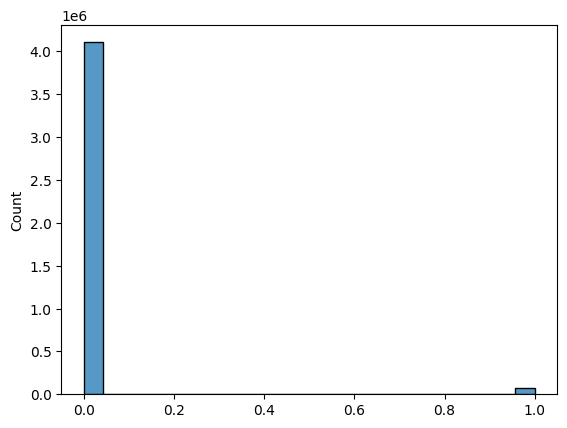

In [192]:
sns.histplot(scores.values.flatten())

In [195]:
scores = (scores + scores.T)/2

In [196]:
scores.to_csv("scores_deepseek_v3.csv")

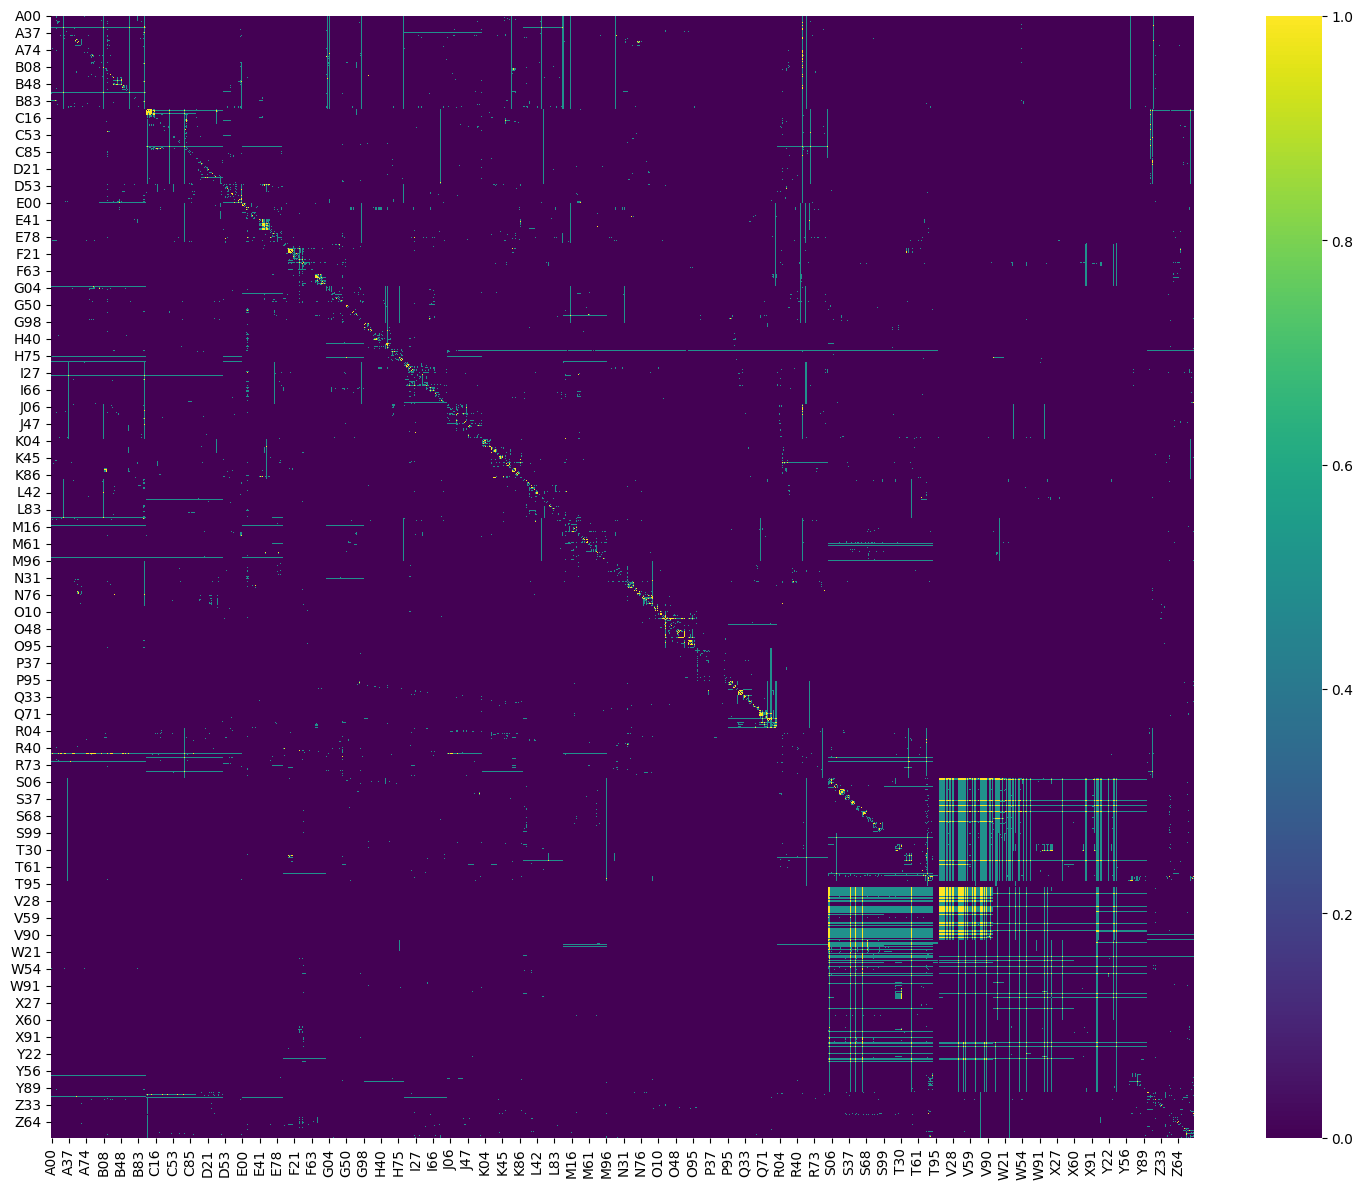

In [197]:
plt.figure(figsize=(15, 12))
sns.heatmap(scores, cmap ='viridis')
plt.tight_layout()
plt.savefig("deepseek_v3.png", dpi=300, bbox_inches='tight')
plt.show()